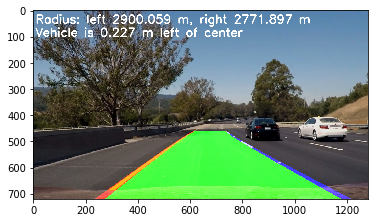

In [1]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import math
%matplotlib inline

img = np.zeros((720,1280),np.float32)
objpoints = np.zeros((6*9,3), np.float32)
imgpoints = np.mgrid[0:9,0:6].T.reshape(-1,2)

# CAMERA CALIBRATION
def cam_cal(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
    # Draw and display the corners
    img_out = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    return img_out

#Binary imgage
def abs_sobel_thresh(img, orient, thresh_min, thresh_max):    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray,cv2.CV_64F,1,0)
    if orient == 'y':
        sobel = cv2.Sobel(gray,cv2.CV_64F,0,1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    sxbinary = np.zeros_like(scaled_sobel)
            # is > thresh_min and < thresh_max
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)]=1
    # 6) Return this mask as your binary_output image
    binary_output =  sxbinary
    return binary_output

def hls_select(img, thresh):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    binary_output = binary # placeholder line
    return binary_output

def bin_it(image,threshold):
    output_bin = np.zeros_like(image)
    output_bin[(image>=threshold[0]) & (image <= threshold[1])]=1
    return output_bin

def rgb_y(img):
    bin_thresh = [20,255]
    lower = np.array([255,180,0],dtype="uint8")
    upper = np.array([255,255,170],dtype="uint8")
    mask = cv2.inRange(img,lower,upper)
    rgb_y = cv2.bitwise_and(img,img,mask=mask).astype(np.uint8)
    rgb_y = cv2.cvtColor(rgb_y,cv2.COLOR_RGB2GRAY)
    rgb_y = bin_it(rgb_y,bin_thresh)
    return rgb_y          

def rgb_w(img):
    bin_thresh = [20,255]
    lower = np.array([100,100,200],dtype="uint8")
    upper = np.array([255,255,255],dtype="uint8")
    mask = cv2.inRange(img,lower,upper)
    rgb_w = cv2.bitwise_and(img,img,mask=mask).astype(np.uint8)
    rgb_w = cv2.cvtColor(rgb_w,cv2.COLOR_RGB2GRAY)
    rgb_w = bin_it(rgb_w,bin_thresh)
    return rgb_w 

def hls_y(img):
    bin_thresh = [20,255]
    lower = np.array([20,120,80],dtype="uint8")
    upper = np.array([45,200,255],dtype="uint8")
    mask = cv2.inRange(img,lower,upper)
    hls_y = cv2.bitwise_and(img,img,mask=mask).astype(np.uint8)
    hls_y = cv2.cvtColor(hls_y,cv2.COLOR_HLS2RGB)
    hls_y = cv2.cvtColor(hls_y,cv2.COLOR_RGB2GRAY)
    hls_y = bin_it(hls_y,bin_thresh)
    return hls_y

# UNDISTORT    
# UNWARP Perspective transform

img_size = (img.shape[1], img.shape[0])
src = np.float32([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],[((img_size[0] / 6) - 10), img_size[1]],[(img_size[0] * 5 / 6) + 60, img_size[1]],
[(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32([[(img_size[0] / 4), 0],[(img_size[0] / 4), img_size[1]],[(img_size[0] * 3 / 4), img_size[1]],
[(img_size[0] * 3 / 4), 0]])

def warper(img, src, dst):
    # Compute and apply perpective transform
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)  
    # keep same size as input image
    return warped
def unwarper(img,src,dst):
    Minv = cv2.getPerspectiveTransform(dst,src)
    unwarp = cv2.warpPerspective(img,Minv,img_size,flags=cv2.INTER_LINEAR)
    return unwarp

# ISOLATE LANES
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),
#         (win_xleft_high,win_y_high),(0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),
#         (win_xright_high,win_y_high),(0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

            
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty,out_img = find_lane_pixels(binary_warped)
                
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')   
    return out_img

# Plot lanes and drive area
def drive_area(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    inner_lane = np.polyfit(left_fit,right_fit,2).T
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    ## Visualization ##
    pt1 = np.vstack((left_fitx,ploty)).T
    pt2 = np.vstack((right_fitx,ploty)).T
    pts = np.concatenate((pt1,np.flip(pt2, axis=0)))
    cv2.fillPoly(out_img,np.int32([pts]),color=[0,255,0])
    cv2.polylines(out_img,np.int32([pt1]),0,(255,0,0),thickness=25)
    cv2.polylines(out_img,np.int32([pt2]),0,(0,0,255),thickness=25)
    
# Text image labels
    # Pixels to meters conversion
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    y_eval = np.max(ploty)
    
    # Curvature
    left_curv = round(((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0]),3)
    right_curv = round(((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0]),3)

    left_pos = (left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2])
    right_pos = (right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2])
    
    # center alignment 
    camera_center = (left_pos+right_pos)/2
    distance_from_center = (img.shape[1]/2 - camera_center)
    center_diff = round((xm_per_pix*distance_from_center),3)

    return out_img,center_diff,left_curv,right_curv

def curv(img,center_diff,left_curv,right_curv):
    if center_diff <= 0:
        side_pos = 'left'
    else:
        side_pos = 'right'
        
    cv2.putText(img,('Radius: left '+ str(left_curv) + ' m, right ' + str(right_curv) + " m"),org=(10,50),
            fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale=1.5,color = (255,255,255),thickness = 3,lineType=cv2.LINE_AA)
    cv2.putText(img,('Vehicle is '+str(abs(center_diff))+' m '+side_pos+' of center'),org=(10,100),
            fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale=1.5,color = (255,255,255),thickness = 3,lineType=cv2.LINE_AA)
    return img

    
def process_image(image):
    img = mpimg.imread(image)
    img_out = cam_cal(img)
    #hls_binary = hls_select(img_out, thresh=(20,45))
    rgb_yellow = rgb_y(img_out)
    rgb_white = rgb_w(img_out)
    hls_yellow = hls_y(img_out)
    sobel_binary = abs_sobel_thresh(img_out,orient='x', thresh_min=50, thresh_max=255)
    #combined_bin_img = hls_binary & sobel_binary
    combined_bin_img = np.zeros_like(hls_yellow)
    combined_bin_img[(hls_yellow == 1)|(rgb_yellow == 1)|(rgb_white == 1)|(sobel_binary==1)] = 1
    warp = warper(combined_bin_img,src,dst)
    #isolate_lanes = fit_polynomial(warp) 
    drive_img,center_diff,left_curv,right_curv = drive_area(warp)
    unwarp = unwarper(drive_img,src,dst)
    result = cv2.addWeighted(img.astype(np.uint8),0.9,unwarp.astype(np.uint8),1,0)
    txt_img = curv(result,center_diff,left_curv,right_curv)
    return result

def processed_image(image):
    img = np.copy(image)
    img_out = cam_cal(img)
    #hls_binary = hls_select(img_out, thresh=(20,45))
    rgb_yellow = rgb_y(img_out)
    rgb_white = rgb_w(img_out)
    hls_yellow = hls_y(img_out)
    sobel_binary = abs_sobel_thresh(img_out,orient='x', thresh_min=50, thresh_max=255)
    #combined_bin_img = hls_binary & sobel_binary
    combined_bin_img = np.zeros_like(hls_yellow)
    combined_bin_img[(hls_yellow == 1)|(rgb_yellow == 1)|(rgb_white == 1)|(sobel_binary==1)] = 1
    warp = warper(combined_bin_img,src,dst)
    #isolate_lanes = fit_polynomial(warp) 
    drive_img,center_diff,left_curv,right_curv = drive_area(warp)
    unwarp = unwarper(drive_img,src,dst)
    result = cv2.addWeighted(img.astype(np.uint8),0.9,unwarp.astype(np.uint8),1,0)
    txt_img = curv(result,center_diff,left_curv,right_curv)
    return result

FINAL = process_image('test_images/test6.jpg')
#mpimg.imsave('output_images/test6.jpg',FINAL)
plt.imshow(FINAL)


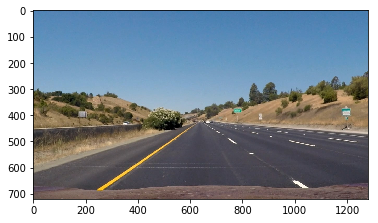

In [2]:
# CAMERA CALIBARATION
img = mpimg.imread('test_images/straight_lines1.jpg')
img_out = cam_cal(img)
mpimg.imsave('output_images/camera_calibaration.jpg',img_out)
plt.imshow(img_out)

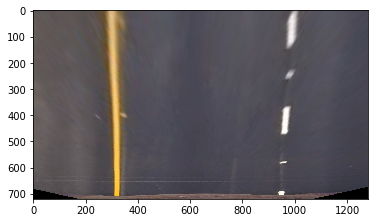

In [3]:
# WARPED IMAGE
# camera calibration
img_out = cam_cal(img)
# Perspective Transform
warp = warper(img_out,src,dst)
mpimg.imsave('output_images/warped_image.jpg',warp)
plt.imshow(warp,cmap='gray')

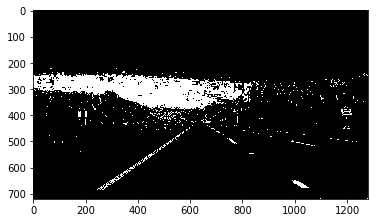

In [4]:
# BINARY 
# camera calibration
img_out = cam_cal(img)
# binary
rgb_yellow = rgb_y(img_out)
rgb_white = rgb_w(img_out)
hls_yellow = hls_y(img_out)
sobel_binary = abs_sobel_thresh(img_out,orient='x', thresh_min=50, thresh_max=255)
combined_bin_img = np.zeros_like(hls_yellow)
combined_bin_img[(hls_yellow == 1)|(rgb_yellow == 1)|(rgb_white == 1)|(sobel_binary==1)] = 1
# visualize
mpimg.imsave('output_images/binary_image.jpg',combined_bin_img,cmap='gray')
plt.imshow(combined_bin_img,cmap='gray')

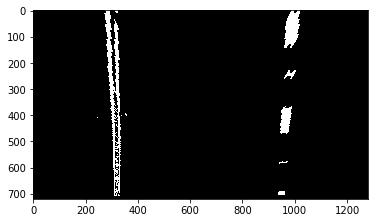

In [5]:
# LANE
# camera calibration
img_out = cam_cal(img)
#Binary
rgb_yellow = rgb_y(img_out)
rgb_white = rgb_w(img_out)
hls_yellow = hls_y(img_out)
sobel_binary = abs_sobel_thresh(img_out,orient='x', thresh_min=50, thresh_max=255)
combined_bin_img = np.zeros_like(hls_yellow)
combined_bin_img[(hls_yellow == 1)|(rgb_yellow == 1)|(rgb_white == 1)|(sobel_binary==1)] = 1
# Perspective Transform
warp = warper(combined_bin_img,src,dst)
# visualize
mpimg.imsave('output_images/lane_detection.jpg',warp,cmap='gray')
plt.imshow(warp,cmap='gray')

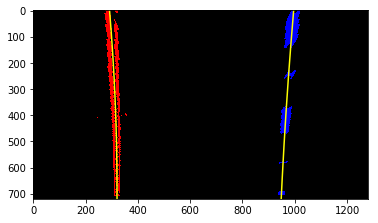

In [6]:
# LANE PIXELS
isolate_lanes = fit_polynomial(warp)
mpimg.imsave('output_images/lane_pixels.jpg',isolate_lanes)
plt.imshow(isolate_lanes)

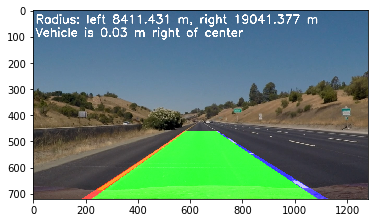

In [7]:
# FINAL IMAGE
drive_area,center_diff,left_curv,right_curv = drive_area(warp)
unwarp = unwarper(drive_area,src,dst)
result = cv2.addWeighted(img,0.8,unwarp,1,0)
txt_img = curv(result,center_diff,left_curv,right_curv)
mpimg.imsave('output_images/straight_lines2.jpg',txt_img)
plt.imshow(txt_img)

In [93]:
# VIDEO
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Output_video = 'output1_tracked.mp4'
Input_video = 'project_video.mp4'
clip1 = VideoFileClip(Input_video)
#clip1 = VideoFileClip(Input_video).subclip(20,23)
video_clip = clip1.fl_image(processed_image)
video_clip.write_videofile(Output_video,audio=False)


[MoviePy] >>>> Building video output1_tracked.mp4
[MoviePy] Writing video output1_tracked.mp4


100%|█████████▉| 1260/1261 [18:13<00:00,  1.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output1_tracked.mp4 

